In [ ]:
__author__ = "Matteo Pariset"

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.4"

In [2]:
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import vmap, value_and_grad # type: ignore

from jax import tree_map  # type: ignore
from jax.lax import fori_loop

In [3]:
import optax
from scipy.interpolate import UnivariateSpline

In [4]:
from datasets import CovidDataset
from plotting import *

# Baselines for Covid evolution experiment

In [5]:
ground_truth_evolution = CovidDataset.load_ground_truth_evolution()

focus_countries = ["United States", "United Kingdom", "Germany", "Denmark", "Canada", "Japan", "France", "Sweden", "Switzerland", "Brazil", "India", "Netherlands", "Italy", "Turkey", "Spain", "Belgium", "Ireland", "Slovenia", "Mexico", "Poland", "South Africa"]
focus_continent = ["Americas",      "Europe",         "Europe",  "Europe",  "Americas","Asia", "Europe", "Europe", "Europe",      "Americas","Asia", "Europe",      "Europe","Europe", "Europe","Europe",  "Europe",  "Europe",   "Americas","Europe", "Africa"]
country_embs = pd.read_csv(f"{CovidDataset.get_dataset_name()}_country_embs.csv", index_col=0).rename_axis("location", axis=0).loc[focus_countries]

common_countries = country_embs.join(ground_truth_evolution, how="inner").index.get_level_values(0).unique().to_numpy()

array(['Belgium', 'Brazil', 'Canada', 'Denmark', 'France', 'Germany',
       'India', 'Ireland', 'Italy', 'Japan', 'Mexico', 'Netherlands',
       'Poland', 'Slovenia', 'South Africa', 'Spain', 'Sweden',
       'Switzerland', 'Turkey', 'United Kingdom', 'United States'],
      dtype=object)

In [6]:
# Select focus variant and focus continent
variant_name = "Delta"
continent = "Europe"

In [7]:
ground_truth = ground_truth_evolution.loc[pd.DataFrame({'country': focus_countries, 'continent': focus_continent}).groupby('continent').agg(list).loc[continent, "country"]].loc[:,variant_name]

In [8]:
ground_mix = ground_truth.groupby('date').agg('mean')
ground_mix

date
2021-04-05    0.000554
2021-04-19    0.003082
2021-05-03    0.016139
2021-05-17    0.039794
2021-05-31    0.082526
2021-06-14    0.172422
2021-06-28    0.401134
2021-07-12    0.774248
2021-07-26    0.891427
2021-08-09    0.938390
Name: Delta, dtype: float64

In [9]:
ground_idxs = ((ground_mix.index - ground_mix.index[0]).to_series().dt.days).to_numpy()

ground_dates = ground_mix.index

ground_meas = ground_truth.groupby("date").agg("mean")

In [10]:
# Load initial and final dates
t0 = CovidDataset.init_date
t1 = CovidDataset.end_date

## Baseline 1: SIR model

In [11]:
SUSCEPTIBLE = 0
INFECTED = 1
RECOVERED = 2

S_TO_I = 'beta'
I_TO_R = 'gamma'

In [12]:
N = 3_759_000

In [13]:
init_params = {
    'beta': 0.013,                     # susceptible ---> infected
    'gamma': 0.089,                    # infected    ---> recovered
}

In [14]:
delta_time = .2
def evo_step(params, state, idx=None, delta_time=delta_time):
    delta_state = jnp.array([
        - params[S_TO_I] * state[SUSCEPTIBLE] * state[INFECTED], 
        + params[S_TO_I] * state[SUSCEPTIBLE] * state[INFECTED] + params[I_TO_R] * state[INFECTED],
        + params[I_TO_R] * state[INFECTED]
    ]) * delta_time

    # next_state = jnp.clip(state + delta_state, 0., 1.)
    next_state = state + delta_state

    return next_state, next_state

In [15]:
init_date, end_date = pd.to_datetime("2021-04-05"), pd.to_datetime("2021-08-09")

In [16]:
def fast_evo(params, init_state, steps_num):
    raw_preds = jax.lax.scan(partial(evo_step, params), init_state, None, length=steps_num)[1]
    return raw_preds

In [17]:
init_frac = jnp.array([1-ground_mix.iloc[0], ground_mix.iloc[0], 0.])

In [18]:
simulation_steps_num = int(126/delta_time)+1
# simulation_steps_num = 253

pred_idxs = jnp.linspace(0, 126, simulation_steps_num)
checkpoints_mask = jnp.isin(pred_idxs, ground_idxs)

assert checkpoints_mask.sum() == ground_idxs.shape[0]

# seqs_num = CovidDataset.load_sequence_nums().to_numpy()
# labels = (ground_mix[variant_name].to_numpy() * seqs_num).cumsum()
labels = ground_mix.to_numpy() #.cumsum()

def pred_mix_to_inc(preds):
    cum_checkpoints = preds[checkpoints_mask,INFECTED]
    inc_checkpoints = jnp.concatenate([cum_checkpoints[:1], cum_checkpoints[1:] - cum_checkpoints[:-1]])
    # inc_num_checkpoints = seqs_num * inc_checkpoints
    inc_num_checkpoints = inc_checkpoints
    return inc_num_checkpoints

def pred_mix_to_seqs(preds):
    cum_checkpoints = preds[checkpoints_mask,INFECTED]
    return cum_checkpoints


def _sir_loss(params, init_state):
    predicted_cum_all = fast_evo(params, init_state, simulation_steps_num)

    pred_seqs_num = pred_mix_to_seqs(predicted_cum_all)

    return jnp.abs(pred_seqs_num - labels).mean()

sir_loss = value_and_grad(_sir_loss)

In [20]:
opt = optax.adamw(1e-3)
init_opt_state = opt.init(init_params)

In [21]:
def training_step(params, init_state, opt_state):
    loss, grad = sir_loss(params, init_state)

    print(loss, end=", ")

    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)

    return params, opt_state

In [22]:
params = init_params
opt_state = init_opt_state
training_step(params, init_frac, opt_state)

16.30535, 

({'beta': Array(0.01199998, dtype=float32),
  'gamma': Array(0.08799997, dtype=float32)},
 (ScaleByAdamState(count=Array(1, dtype=int32), mu={'beta': Array(114.60082, dtype=float32, weak_type=True), 'gamma': Array(180.96594, dtype=float32, weak_type=True)}, nu={'beta': Array(1313.3348, dtype=float32, weak_type=True), 'gamma': Array(3274.8674, dtype=float32, weak_type=True)}),
  EmptyState(),
  EmptyState()))

In [36]:
for _ in range(50):
    params, opt_state = training_step(params, init_frac, opt_state)

0.17714915, 0.17595226, 0.17487547, 0.17390409, 0.17302513, 0.1722275, 0.17150165, 0.17083926, 0.17023326, 0.16967727, 

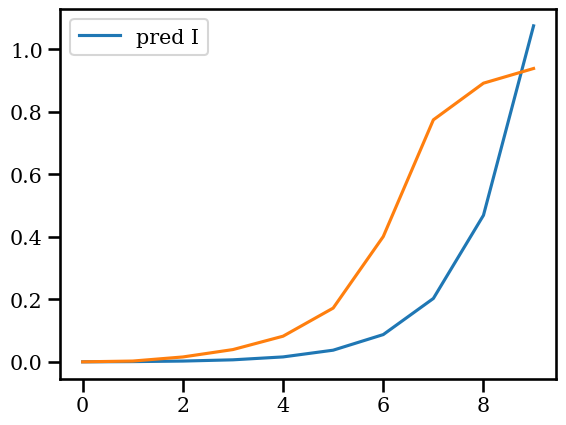

In [37]:
sim_vals = fast_evo(params, init_frac, simulation_steps_num)

plt.plot(pred_mix_to_seqs(sim_vals), label="pred I")

plt.plot(labels);

plt.legend();

## Baseline 2: Spline interpolation

In [38]:
sequences_evo_by_country = CovidDataset.load_sequence_nums()

In [39]:
sir_input = ground_truth.swaplevel(0,1).groupby('date').mean()
sir_input = sir_input.apply(lambda x: x).to_frame()
sir_input = sir_input.rename({'Delta': 'daily_confirm'}, axis=1)
sir_input

,daily_confirm
date,
2021-04-05,0.000554
2021-04-19,0.003082
2021-05-03,0.016139
2021-05-17,0.039794
2021-05-31,0.082526
2021-06-14,0.172422
2021-06-28,0.401134
2021-07-12,0.774248
2021-07-26,0.891427


In [40]:
def spline_from_training(training_mask):
    spline = UnivariateSpline((sir_input.index - t0).days[training_mask], sir_input['daily_confirm'].iloc[training_mask], k=3)
    return spline

In [41]:
# Train on 4 initial measurements (prediction from the past)
past_training_set = jnp.where(jnp.array([True] * 4 + [False] * 6))

# Train on 2 initial and final measurements (prediction from endpoints)
endpoints_training_set = jnp.where(jnp.array([True] * 2 + [False] * 6 + [True] * 2))

In [42]:
past_spline = spline_from_training(past_training_set)
endpoints_spline = spline_from_training(endpoints_training_set)

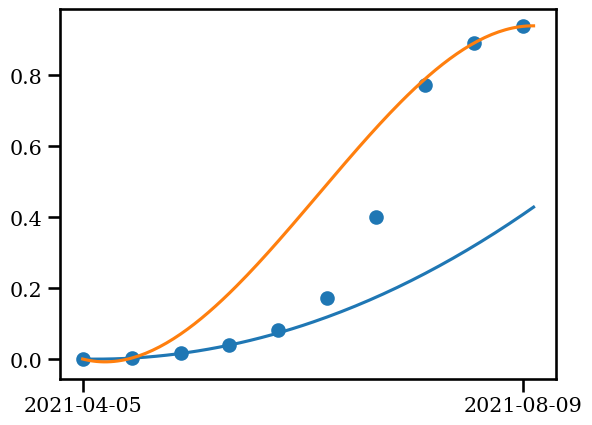

In [43]:
plt.scatter(sir_input.index, sir_input['daily_confirm'])
plt.plot(t0 + pd.to_timedelta(jnp.arange(0, 130), unit="day"), past_spline(jnp.arange(0, 130)))
plt.plot(t0 + pd.to_timedelta(jnp.arange(0, 130), unit="day"), endpoints_spline(jnp.arange(0, 130)))

plt.xticks([t0, t1]);

## Compare UnbalancedSB with Baselines

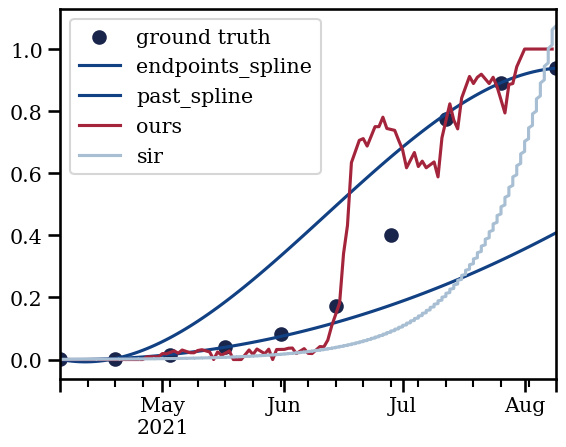

In [44]:
plt.scatter(sir_input.index, ground_meas, label="ground truth", color=palette[0])

endpoints_spline_res = pd.DataFrame({
    'endpoints_spline': endpoints_spline(jnp.arange(0, 127))
}, index= t0 + pd.to_timedelta(jnp.arange(0, 127), unit="day"))

endpoints_spline_res.plot(ax=plt.gca(), color=palette[1])

past_spline_res = pd.DataFrame({
    'past_spline': past_spline(jnp.arange(0, 127))
}, index= t0 + pd.to_timedelta(jnp.arange(0, 127), unit="day"))

past_spline_res.plot(ax=plt.gca(), color=palette[1])

our_res = pd.DataFrame({
    'ours': jnp.load("../reproducibility/covid_v4_preds_europe.npy"),
}, index=(t0 + pd.to_timedelta(jnp.arange(0, 100)/100*127, unit="day")).normalize())

our_res.plot(ax=plt.gca(), color=palette[4])

sir_res = pd.DataFrame({
    'sir': sim_vals[:,INFECTED]
}, index=t0 + pd.to_timedelta(pred_idxs, unit="day"))

sir_res.plot(ax=plt.gca(), color=palette[2])

plt.legend();

export_fig("usb_covid_baseline_comparisons_europe_delta")

In [45]:
def score_predictions(gap):
    return (gap.applymap(jnp.square).mean(axis=1)).apply(jnp.sqrt)

In [46]:
def find_closest(dates, res):
    return dates.to_series().apply(lambda d: (res.iloc[int(jnp.where(d <= res.index)[0].min(initial=res.shape[0]-1))]+res.iloc[int(jnp.where(res.index <= d)[0].max())])/2)

In [47]:
preds_at_checkpoints = pd.DataFrame([
    endpoints_spline_res.loc[ground_dates, "endpoints_spline"],
    past_spline_res.loc[ground_dates, "past_spline"],
    find_closest(ground_dates, our_res)['ours'],
    find_closest(ground_dates, sir_res)['sir']
])
preds_at_checkpoints

date,2021-04-05,2021-04-19,2021-05-03,2021-05-17,2021-05-31,2021-06-14,2021-06-28,2021-07-12,2021-07-26,2021-08-09
endpoints_spline,0.000554,0.003082,0.070759,0.186557,0.333449,0.494408,0.652409,0.790424,0.891427,0.938390
past_spline,0.000554,0.003082,0.016139,0.039794,0.074119,0.119186,0.175065,0.241828,0.319545,0.408289
ours,0.000000,0.000000,0.023148,0.020643,0.032522,0.145257,0.741141,0.768908,0.836453,1.000000
sir,0.000560,0.001301,0.003022,0.007016,0.016289,0.037809,0.087707,0.203178,0.469136,1.074727


### Compute L2 loss

In [48]:
score_predictions(preds_at_checkpoints - ground_meas.to_numpy())

endpoints_spline      0.1595496
past_spline          0.30749622
ours                0.112300806
sir                  0.25397488
dtype: object